In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt

**The following poisson problem with Dirichlet boundary condition is given:**
$$-\Delta u = f \quad in \; \Omega = (0,1)^2$$
$$ u = g \quad on \quad \partial \Omega \quad$$

In [2]:
#given exact solution
def u(x,y):
    return pow(x,4)*pow(y,5)-17*np.sin(x*y)

In [3]:
#right-hand-side of the poisson equation
def fun(x,y):
    return (17*(x**2 + y**2)*np.sin(x*y) + 4*x**2*y**3+(5*x**2 + 3*y**2))

**First, the components of the following equation will be assembled:**

$$A \underline{u} = \underline{f} + B\underline{g} \Longleftrightarrow A \underline{u} - B\underline{g} = \underline{f} = -\Delta u $$

In [4]:
# matrix A only involves inner nodes. so for m inner nodes, A is an (m x m)-matrix
def matrix_A(h):
    N = int(1/h)
    m = pow(N-1,2)
    A = pow(h,-2)*(np.zeros((m,m))+4*np.eye(m) - np.eye(m,k=1) - np.eye(m,k=-1) - np.eye(m,k=N-1) - np.eye(m,k=-(N-1)))
    
    # insert zeros for neighbours of inner nodes that are next to the boundary, because of lexicographical order
    for i in range(N-2):
        #for successors:
        A[(i+1)*(N-1)-1][(i+1)*(N-1)] = 0
        #for predecessors
        A[(i+1)*(N-1)][(i+1)*(N-1)-1] = 0
   
    return A

In [5]:
# example for matrix A
n = 2
h = pow(2,-n)
A = matrix_A(h)
A

array([[ 64., -16.,   0., -16.,   0.,   0.,   0.,   0.,   0.],
       [-16.,  64., -16.,   0., -16.,   0.,   0.,   0.,   0.],
       [  0., -16.,  64.,   0.,   0., -16.,   0.,   0.,   0.],
       [-16.,   0.,   0.,  64., -16.,   0., -16.,   0.,   0.],
       [  0., -16.,   0., -16.,  64., -16.,   0., -16.,   0.],
       [  0.,   0., -16.,   0., -16.,  64.,   0.,   0., -16.],
       [  0.,   0.,   0., -16.,   0.,   0.,  64., -16.,   0.],
       [  0.,   0.,   0.,   0., -16.,   0., -16.,  64., -16.],
       [  0.,   0.,   0.,   0.,   0., -16.,   0., -16.,  64.]])

In [6]:
# matrix A in sparse format. this is a lot harder to assemble because of the single deletions
def sparse_A(h):
    N = int(1/h)
    m = pow(N-1,2)
    A = pow(h,-2)*(4*sp.eye(m) - sp.eye(m,k=1) - sp.eye(m,k=-1) - sp.eye(m,k=N-1) - sp.eye(m,k=-(N-1)))
    
    # insert zeros for neighbours of inner nodes that are next to the boundary, because of lexicographical order
    for i in range(N-2):
        A.data[(i+1)*(N-1)*5-1*(N-1)-2-1]=0 
        A.data[(i+1)*(N-1)*5-1*(N-1)]=0
  
    return A

In [7]:
#check that sparse matrix is equal to dense matrix
s=sparse_A(h)
d=A-s.todense()
np.linalg.norm(d)

0.0

In [8]:
def vector_f(h):
    N = int(1/h)
    l = pow(N-1,2)
    f = np.zeros(l)
    for i in range(N-1):
        for k in range(N-1):
            f[k+i*(N-1)]=fun((k+1)/(N),(i+1)/(N))       
    return f

In [9]:
# for m inner nodes and l boundary nodes, B is a (m x l)-matrix
def sparse_B(h):
    N = int(1/h)
    m = pow(N-1,2)
    l = 4*N
    B = np.zeros((m,l))
    
    # since the lower and left boundary values are zero, only entries for the right
    # and upper boundary nodes are needed
    for i in range(N-1):
        #right boundary:
        B[(i+1)*(N-1)-1][2*(N+i-1)] = pow(h,-2)
        #upper boundary:
        B[-(N-1)+i][-N+i] = pow(h,-2)
    B = sp.csr_matrix(B)
    return B

In [10]:
# example for B
n = 2
h = pow(2,-n)
B = sparse_B(h)
B.todense()

matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.,
          0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         16.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,
          0., 16.,  0.]])

In [11]:
# vector g of length 4*N contains the boundary values which satisfy u(x,y)
def vector_g(h):
    N = int(1/h)
    l = 4*N
    g = np.zeros(l)
    
    # upper boundary, where y=1
    for i in range(N):
        g[-N+i] = u((i+1)*h,1)
    # right boundary, where x=1    
    for i in range(N-1):    
        g[N+2+2*i] = u(1,(i+1)*h)
    return g    

In [12]:
# example for g
n = 2
h = pow(2,-n)
g = vector_g(h)
g

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  -4.20489074,   0.        ,
        -8.11898416,   0.        , -11.35055423,   0.        ,
        -4.20196106,  -8.08773416, -11.27145267, -13.30500674])

In [13]:
n = 3
h = pow(2,-n)
N = pow(2,n)

In [14]:
A=sparse_A(h)
f=vector_f(h)
B=sparse_B(h)
g=vector_g(h)

**Now, the linear system Au = RHS will be solved.**

In [15]:
RHS = f+B.dot(g)
appr_u = sp.linalg.spsolve(A,RHS)

#### **Error and Consistency**

In [16]:
def exact_solution(h):
    N = int(1/h)
    l = pow(N-1,2)
    v = np.zeros(l)
    for i in range(N-1):
        for k in range(N-1):
            v[k+i*(N-1)]=u((k+1)/(N),(i+1)/(N))       
    return v

In [17]:
grid = np.zeros(7)
error_eukl = np.zeros(7)
error_inf = np.zeros(7)

for i in range(7):
    grid[i]=pow(2,-(i+2))
    h = grid[i]
    A = sparse_A(h)
    f = vector_f(h)
    B = sparse_B(h)
    g = vector_g(h)
    RHS = f+B.dot(g)
    appr_u = sp.linalg.spsolve(A,RHS)
    v = exact_solution(h)
    x = (appr_u - v)
    print(appr_u[-1],v[-1])
    error_eukl[i] = np.linalg.norm(x)
    error_inf[i] = np.linalg.norm(x,ord = np.inf)
    

-8.180678655519896 -8.991060763833046
-8.270439559649837 -11.480133561857317
-10.760438683213074 -12.53128157061408
-12.195353800544211 -12.961737935032156
-12.821966137009229 -13.145532611303409
-13.087791494720165 -13.228477586622512
-13.203877060573376 -13.267565784364171


Text(0.5, 0, 'step size h')

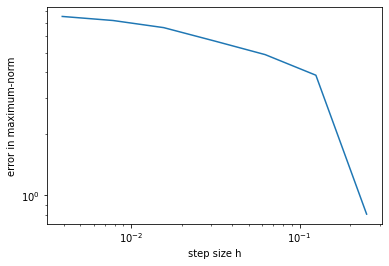

In [18]:
plt.loglog(grid,error_inf)
plt.ylabel('error in maximum-norm')
plt.xlabel('step size h')

Text(0.5, 0, 'step size h')

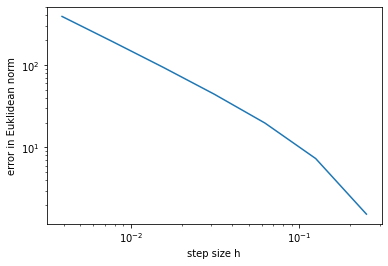

In [19]:
plt.loglog(grid,error_eukl)
plt.ylabel('error in Euklidean norm')
plt.xlabel('step size h')

Obviously the algorithm is not consistent, although it is supposed to be of order 2.
Even after several hours of debugging, I couldn't figure out the problem.